(econmt-bayesian)=
# Bayesian Regression

In this chapter, we'll look at how to perform analysis and regressions using Bayesian techniques.

Let's import a few of the packages we'll need first. You may need to install some of these; the Chapter on {ref}`code-preliminaries` covers how to install new packages.

In [1]:
import numpy as np
import pandas as pd
from rich import inspect
import matplotlib.pyplot as plt
import warnings

# Plot settings
plt.style.use(
    "https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt"
)

# Pandas: Set max rows displayed for readability
pd.set_option("display.max_rows", 6)

# Set seed for random numbers
seed_for_prng = 78557
prng = np.random.default_rng(seed_for_prng)  # prng=probabilistic random number generator
# Turn off warnings
warnings.filterwarnings('ignore')

## Introduction

The biggest difference between the Bayesian and frequentist approaches (that we've seen in the other chapters) is probably that, in Bayesian models, the parameters are not assumed to be fixed but instead are treated as random variables whose uncertainty is described using probability distributions. The data are considered fixed. You might see the 'inverse probabiliy' formulation of a Bayesian model written as $p(\theta | y)$ where the $y$ are the data, and the $\theta$ are the model parameters. An interesting aspect of Bayesianism is that there is just one estimator: Bayes' theorem.

This is a contrast with the frequentist view, which holds that the data are random but the model parameters are fixed, and models often expressed as functions, for example $f(y | \theta)$. Frequentist inference typically involves deriving estimators for the model parameters, and these are usually created to minimise the bias, minimise the variance, or maximise the efficiency.

As a reminder, Bayes' theorem says that ${\displaystyle P(A\mid B)={\frac {P(B\mid A)P(A)}{P(B)}}}$, where $A$ and $B$ are distinct events and $P(A)$ is the probability of event A happening. When dealing with data and model parameters, and ignoring a rescaling factor, this can be written as:

$$
p({\boldsymbol{\theta }}|{\boldsymbol{y}})\propto p({\boldsymbol{y}}|{\boldsymbol{\theta }})p({\boldsymbol{\theta }}).
$$

In these equations:

1. $p({\boldsymbol{\theta}})$ is the prior put on model parameters—what we think the distribution will look like.
2. $p({\boldsymbol{y}}|{\boldsymbol{\theta }})$ is the likelihood of this data given a particular set of model parameters.
3. $p({\boldsymbol{\theta }}|{\boldsymbol{y}})$ is the posterior probability of those model parameters given the observed data.

Bayesian modelling proceeds as highlighted in the review article, *Bayesian statistics and modelling* {cite}`van2021bayesian`:

![The Bayesian research cycle.](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs43586-020-00001-2/MediaObjects/43586_2020_1_Fig1_HTML.png?as=webp)

Let's now look at this with a very simple example using bambi


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 17 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.98,0.08,0.81,1.14,0.00,0.00,1612.97,826.68,1.00
beta[0],1.02,0.09,0.87,1.19,0.00,0.00,1576.24,671.48,1.00
beta[1],2.62,0.44,1.86,3.51,0.01,0.01,1261.64,656.28,1.00
sigma,0.89,0.06,0.79,1.02,0.00,0.00,1702.36,957.81,1.01


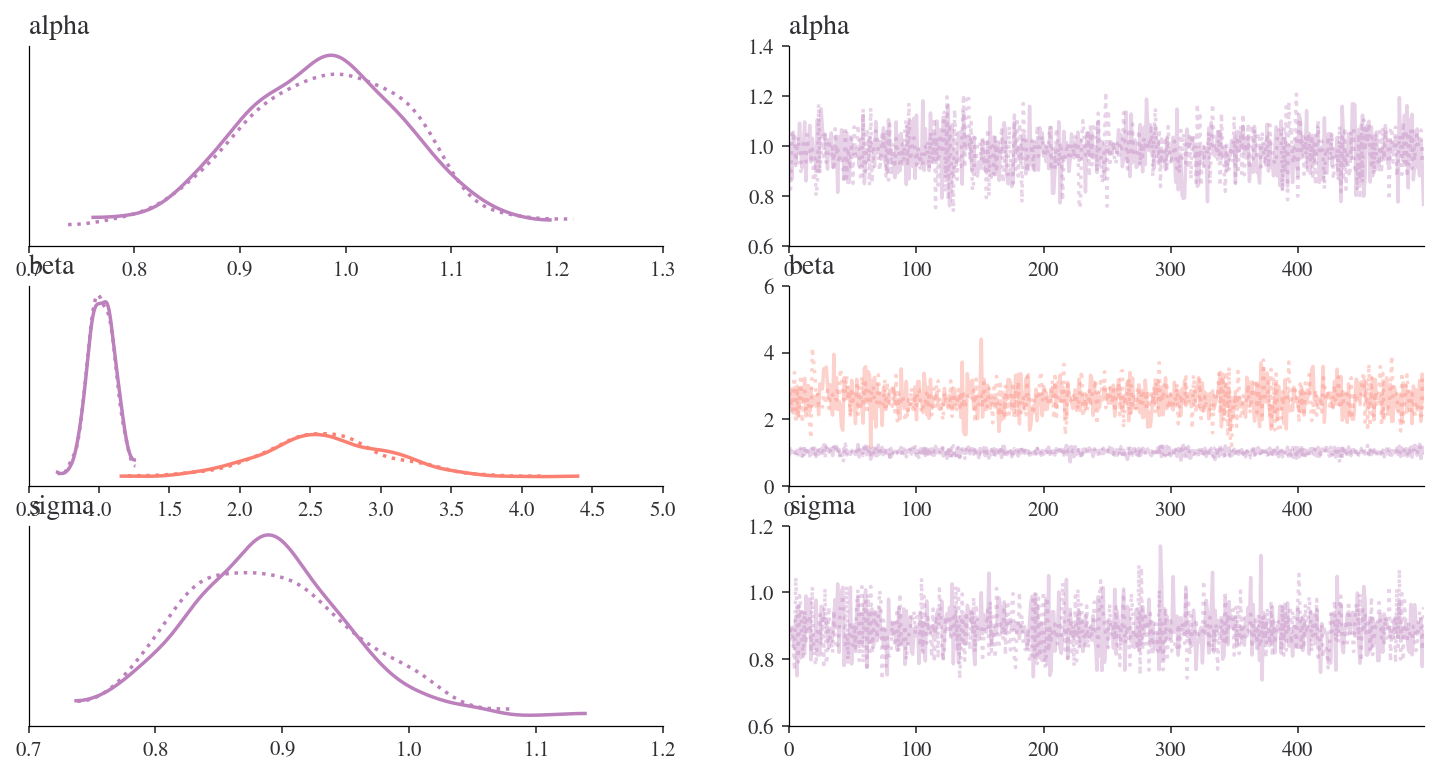

In [3]:
import pymc3 as pm
import arviz as az


# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + np.random.randn(size) * sigma
with pm.Model() as linear_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    trace = pm.sample(500, return_inferencedata=False)
    az.plot_trace(trace)
    display(az.summary(trace, round_to=2))